In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Hyperparameters for training
BATCH_SIZE = 128
EPOCHS = 10  # Keep epochs low for a quick demo
LR = 0.001

# Hyperparameters for Knowledge Distillation
TEMPERATURE = 10.0  # Softens probabilities - 0.4
ALPHA = 0.3        # Weight for soft target loss - 0.7

Using device: cuda


In [ ]:
# --- 1. Load CIFAR-10 Dataset ---
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:09<00:00, 17.6MB/s]


In [ ]:
# --- 2. Define Student and Teacher Models ---

# A simple CNN for the student
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # CIFAR-10 images are 32x32.
        # After conv1: 32x32 -> pool: 16x16
        # After conv2: 16x16 -> pool: 8x8
        # Flattened size: 32 channels * 8 * 8 = 2048
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load a pre-trained Teacher model
# Using torch.hub to get a ResNet-56 pre-trained on CIFAR-10
try:
    teacher_model = torch.hub.load(
        "chenyaofo/pytorch-cifar-models",
        "cifar10_resnet56",
        pretrained=True
    )
    teacher_model = teacher_model.to(DEVICE)
    teacher_model.eval()  # Set to evaluation mode
    print("\nSuccessfully loaded pre-trained teacher model (cifar10_resnet56).")
except Exception as e:
    print(f"\nCould not load teacher model. Error: {e}")
    print("Proceeding without a teacher model will cause the KD part to fail.")
    teacher_model = None

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt


100%|██████████| 3.39M/3.39M [00:00<00:00, 72.2MB/s]



Successfully loaded pre-trained teacher model (cifar10_resnet56).


In [ ]:
# --- 3. Define Loss Function ---

def distillation_loss(student_logits, labels, teacher_logits, T, alpha):
    """
    Knowledge Distillation loss function.

    :param student_logits: Raw logits from the student model
    :param labels: True labels (hard targets)
    :param teacher_logits: Raw logits from the teacher model
    :param T: Temperature for softening
    :param alpha: Weight between soft and hard loss
    :return: The total distillation loss
    """
    # Standard Cross-Entropy loss (hard loss)
    hard_loss = F.cross_entropy(student_logits, labels)

    # Soft loss (KL Divergence between soft student and soft teacher)
    # We use reduction='batchmean' as specified in Hinton's paper.
    # The T*T scaling is to account for the gradients being scaled by 1/T^2
    soft_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)

    # Total loss
    total_loss = (1. - alpha) * hard_loss + alpha * soft_loss
    return total_loss

In [ ]:
# --- 4. Training and Evaluation Loops ---

# Standard evaluation loop
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
def train(model, dataloader, optimizer, loss_fn, is_kd=False, teacher=None):
    model.train()
    for data, labels in dataloader:
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        student_logits = model(data)

        if is_kd:
            assert teacher is not None, "Teacher model must be provided for KD"
            with torch.no_grad():
                teacher_logits = teacher(data)
            loss = loss_fn(student_logits, labels, teacher_logits, T=TEMPERATURE, alpha=ALPHA)
        else:
            # loss_fn is standard nn.CrossEntropyLoss
            loss = loss_fn(student_logits, labels)

        loss.backward()
        optimizer.step()

In [ ]:
# --- 5. Run the Experiment ---

def run_experiment():
    test_accs_baseline = []
    test_accs_kd = []

    # --- Evaluate Teacher Model ---
    if teacher_model is not None:
        print("\n--- Evaluating Pre-trained Teacher Model ---")
        teacher_acc = evaluate(teacher_model, testloader)
        print(f"Teacher Model Test Accuracy: {teacher_acc:.2f}%")
    else:
        print("\nTeacher model not loaded, skipping teacher evaluation.")

    # --- Run 1: Train Baseline Student ---
    print("\n--- Training Student (Baseline) ---")
    student_baseline = StudentModel().to(DEVICE)
    optimizer = optim.Adam(student_baseline.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        train(student_baseline, trainloader, optimizer, criterion, is_kd=False)
        acc = evaluate(student_baseline, testloader)
        test_accs_baseline.append(acc)
        print(f"Epoch {epoch+1}/{EPOCHS} | Baseline Test Accuracy: {acc:.2f}%")

    # --- Run 2: Train Distilled Student ---
    print("\n--- Training Student (with Knowledge Distillation) ---")
    if teacher_model is None:
        print("Cannot run KD training without a teacher model. Skipping.")
        return test_accs_baseline, test_accs_kd

    student_kd = StudentModel().to(DEVICE) # Create a new student instance
    optimizer = optim.Adam(student_kd.parameters(), lr=LR)
    # The loss_fn is now the `distillation_loss` function

    for epoch in range(EPOCHS):
        train(student_kd, trainloader, optimizer, distillation_loss, is_kd=True, teacher=teacher_model)
        acc = evaluate(student_kd, testloader)
        test_accs_kd.append(acc)
        print(f"Epoch {epoch+1}/{EPOCHS} | Distilled Test Accuracy: {acc:.2f}%")

    return test_accs_baseline, test_accs_kd

In [ ]:
# --- 6. Plot Results ---
def plot_results(baseline_accs, kd_accs):
    if not baseline_accs and not kd_accs:
        print("No results to plot.")
        return

    plt.figure(figsize=(10, 6))
    epochs_range = range(1, EPOCHS + 1)

    if baseline_accs:
        plt.plot(epochs_range, baseline_accs, 'o-', label='Baseline Student')
    if kd_accs:
        plt.plot(epochs_range, kd_accs, 'o-', label=f'Distilled Student (T={TEMPERATURE}, alpha={ALPHA})')

    plt.title('Knowledge Distillation Demo')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs_range)
    plt.ylim(min(min(baseline_accs, default=0), min(kd_accs, default=0)) - 5, 100)

    # Show the plot
    print("\nDisplaying results plot...")
    plt.show()


--- Evaluating Pre-trained Teacher Model ---
Teacher Model Test Accuracy: 94.37%

--- Training Student (Baseline) ---
Epoch 1/10 | Baseline Test Accuracy: 58.63%
Epoch 2/10 | Baseline Test Accuracy: 65.91%
Epoch 3/10 | Baseline Test Accuracy: 66.80%
Epoch 4/10 | Baseline Test Accuracy: 69.30%
Epoch 5/10 | Baseline Test Accuracy: 69.79%
Epoch 6/10 | Baseline Test Accuracy: 69.78%
Epoch 7/10 | Baseline Test Accuracy: 71.14%
Epoch 8/10 | Baseline Test Accuracy: 70.03%
Epoch 9/10 | Baseline Test Accuracy: 70.01%
Epoch 10/10 | Baseline Test Accuracy: 70.32%

--- Training Student (with Knowledge Distillation) ---
Epoch 1/10 | Distilled Test Accuracy: 55.74%
Epoch 2/10 | Distilled Test Accuracy: 63.08%
Epoch 3/10 | Distilled Test Accuracy: 66.91%
Epoch 4/10 | Distilled Test Accuracy: 68.27%
Epoch 5/10 | Distilled Test Accuracy: 69.09%
Epoch 6/10 | Distilled Test Accuracy: 70.19%
Epoch 7/10 | Distilled Test Accuracy: 71.23%
Epoch 8/10 | Distilled Test Accuracy: 71.20%
Epoch 9/10 | Distilled T

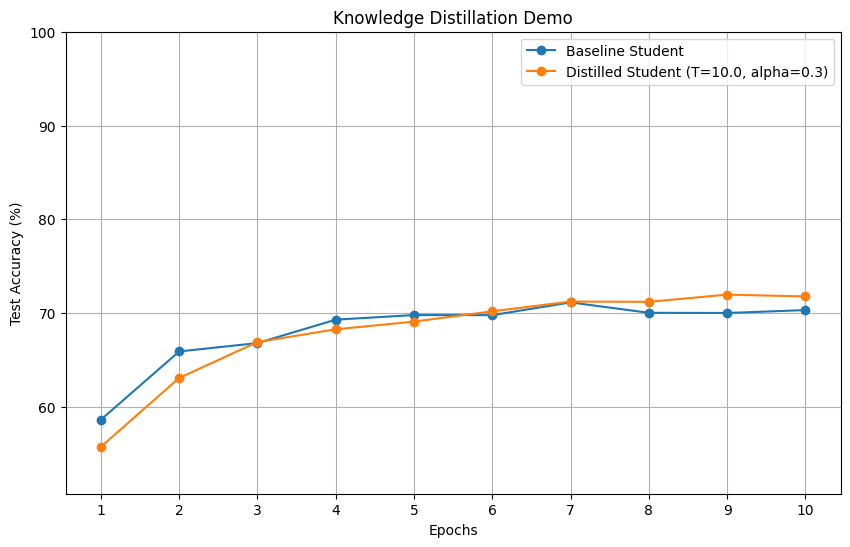

In [ ]:
# --- Main Execution ---
if __name__ == "__main__":
    baseline_accs, kd_accs = run_experiment()
    plot_results(baseline_accs, kd_accs)
